## Installs

In [1]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 10.2 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=0b8fad42d76824b86cb1df4b16f6379df80d784f2a21b37f4279e33ebaa34c59
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [2]:
!pip install iso-639

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 167 kB 8.5 MB/s 
  Created wheel for iso-639: filename=iso_639-0.4.5-py3-none-any.whl size=169061 sha256=12415967c7e8b9b7e5f8911ad2c5a6079c05961593c5f502ea93e8621e78e6af
  Stored in directory: /root/.cache/pip/wheels/47/60/19/6d020fc92138ed1b113a18271e83ea4b5525fe770cb45b9a2e
Successfully built iso-639


In [3]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 6.9 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=ecf502860577940b52752a17db9dce6cd6c1daa860a2f40f3021d2c47f38a02b
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji


In [4]:
!pip install neattext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 114 kB 8.3 MB/s 


In [5]:
#from transformers import pipeline
#classifier = pipeline("text-classification",model='bhadresh-savani/bert-base-uncased-emotion', return_all_scores=True)

##Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import nltk
import re
import seaborn as sns

In [7]:
from urllib.parse import urlparse, parse_qs
from emoji import demojize, replace_emoji
import neattext

In [8]:
from googleapiclient.discovery import build

In [9]:
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
#for sentiment analysis with a score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [10]:
from langdetect import detect, detect_langs
from langdetect import DetectorFactory
from iso639 import languages
DetectorFactory.seed = 1

In [11]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

In [12]:
#youtube api key
api_key = '******'

##Functions

In [13]:
def video_id(value):
    """
    Parses the video id
    Examples:
    - http://youtu.be/SA2iWivDJiE
    - http://www.youtube.com/watch?v=_oPAwA_Udwc&feature=feedu
    - http://www.youtube.com/embed/SA2iWivDJiE
    - http://www.youtube.com/v/SA2iWivDJiE?version=3&amp;hl=en_US
    """
    query = urlparse(value)
    if query.hostname == 'youtu.be':
        return query.path[1:]
    if query.hostname in ('www.youtube.com', 'youtube.com'):
        if query.path == '/watch':
            p = parse_qs(query.query)
            return p['v'][0]
        if query.path[:7] == '/embed/':
            return query.path.split('/')[2]
        if query.path[:3] == '/v/':
            return query.path.split('/')[2]
    # fail?
    return None

In [14]:
def getcomments(videoId, maxResults=200, order='relevance'):
    
    response = []
    
    #MAX_RESULTS is a parameter that shouldnt be changed
    
    MAX_RESULTS = maxResults
    
    # creating youtube resource object
    youtube = build('youtube', 'v3',
                    developerKey=api_key)
    
    # the max results we can get from the api is 100  we need to make sure not to get more then that
    if maxResults > 100:
        n_results = 100
    else:
        n_results = maxResults
    
    #debug prints
    print('max results sets to:',maxResults)
    
    #getting comments using youtube api
    video_response=youtube.commentThreads().list(
            part='snippet',
            order=order,
            maxResults=n_results,
            videoId=videoId,
            ).execute()

    print('fetched so far:',len(video_response['items']))

    #saving the comments in the response variable
    response = video_response['items']
    #getting data for the next page if needed
    ntp = video_response.get('nextPageToken')
    print('is there another page of comments after this?', 'yes' if ntp else 'no')

    #looping the api until we get to MAX_RESULTS number

    while len(response)<MAX_RESULTS and 'nextPageToken' in video_response:

        maxResults -= len(video_response['items'])
        if maxResults > 100:
            n_results = 100
        else:
            n_results = maxResults
        #print('new max results:', maxResults)
        
        if ntp:
            video_response=youtube.commentThreads().list(
            part='snippet',
            order=order,
            maxResults=n_results,
            pageToken=ntp,
            videoId=videoId,
            ).execute()

        response += video_response['items']
        ntp = video_response.get('nextPageToken')
        print('fetched so far:',len(response))
        print('is there another page of comments after this?', 'yes' if ntp else 'no')
        

    print('total comments fetched:', len(response))
    return response

In [15]:
def parse_comments(comments):
    #extracting the relevent data from the json
    comments_dict =[{'textOriginal':comment.get('snippet').get('topLevelComment').get('snippet').get('textOriginal'),
            'likeCount':comment.get('snippet').get('topLevelComment').get('snippet').get('likeCount'),
            'published_date':comment.get('snippet').get('topLevelComment').get('snippet').get('publishedAt'),
            'replyCount':comment.get('snippet').get('totalReplyCount')} 
           for comment in comments]
    #converting the dict to dataframe and converting the string to datetime
    df = pd.DataFrame(comments_dict)
    df['published_date'] = pd.to_datetime(df['published_date'],format='%Y-%m-%dT%H:%M:%SZ')
    return df

In [16]:
def get_language(text):
    try:
        iso_code = detect_langs(text)[0].lang
        return languages.get(alpha2=iso_code).name
    except:
        return 'no lang'

In [17]:
def sentiment_analysis_compound_score(text):
    sid = SentimentIntensityAnalyzer()    
    return sid.polarity_scores(text).get('compound')

In [18]:
def sentiment_analysis(text, neutral_limit = 0.05):
    compound = sentiment_analysis_compound_score(text)
    if compound > neutral_limit:
        return 'positive'
    elif compound < -neutral_limit:
        return 'negative'
    else:
        return 'neutral'

In [19]:
def sentiment_analysis_full(text, neutral_limit = 0.05):
    sid = SentimentIntensityAnalyzer() 
    compound_scroe = sid.polarity_scores(text).get('compound')
    if compound_scroe > neutral_limit:
        sentiment_ind = 'positive'
    elif compound_scroe < -neutral_limit:
        sentiment_ind = 'negative'
    else:
        sentiment_ind = 'neutral'
    return sentiment_ind, compound_scroe

In [20]:
# Edit this One AI API call using our studio at https://studio.oneai.com/?pipeline=3aRxk5

def emotions_api(text):
    #creates dictionary of all emotions
    api_key = "*****"
    url = "https://api.oneai.com/api/v0/pipeline"
    headers = {
    "api-key": api_key, 
    "content-type": "application/json"
    }
    payload = {
    "input": [
                { "speaker": "comments", "utterance": text }
            ],
    "input_type": "conversation",
        "content_type": "application/json",
    "steps": [
        {
        "skill": "emotions"
        }
    ],
    }
    r = requests.post(url, json=payload, headers=headers)
    data = r.json()

    try:
        emotions = data['output'][0]['labels']
    except:
        return None

    return {emotion['name']:emotion['span_text'] for emotion in emotions}

In [21]:
#def get_emotion(text):
 #   return pd.json_normalize(classifier(text)[0]).sort_values('score', ascending=False).head(1).values[0,0]

In [22]:
def get_wordcloud(series, background_color='black'):
    text = " ".join(word for word in series)
    stop_words = stopwords.words("english")
    wordcloud = WordCloud(stopwords=stop_words, background_color=background_color).generate(text)
    plt.figure( figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

###text pre-processing funcs

In [23]:
def remove_punctuation_func(text):
    '''
    Removes all punctuation from a string, if present
    
    Args:
        text (str): String to which the function is to be applied, string
    
    Returns:
        Clean string without punctuations
    '''
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

In [24]:
def remove_url_func(text):
    '''
    Removes URL addresses from a string, if present
    
    Args:
        text (str): String to which the function is to be applied, string
    
    Returns:
        Clean string without URL addresses
    ''' 
    return re.sub(r'https?://\S+|www\.\S+', '', text)

In [25]:
def remove_irr_char_func(text):
    '''
    Removes all irrelevant characters (numbers and punctuation) from a string, if present
    
    Args:
        text (str): String to which the function is to be applied, string
    
    Returns:
        Clean string without irrelevant characters
    '''
    return re.sub(r'[^a-zA-Z]', ' ', text)

In [26]:
def remove_extra_whitespaces_func(text):
    '''
    Removes extra whitespaces from a string, if present
    
    Args:
        text (str): String to which the function is to be applied, string
    
    Returns:
        Clean string without extra whitespaces
    ''' 
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

In [27]:
def remove_english_stopwords_func(text):
    '''
    Removes Stop Words (also capitalized) from a string, if present
    
    Args:
        text (str): String to which the function is to be applied, string
    
    Returns:
        Clean string without Stop Words
    ''' 
    # check in lowercase 

    t = [token for token in word_tokenize(text) if token.lower() not in stopwords.words("english")]
    text = ' '.join(t)    
    return text

In [28]:
def word_count_func(text):
    '''
    Counts words within a string
    
    Args:
        text (str): String to which the function is to be applied, string
    
    Returns:
        Number of words within a string, integer
    ''' 
    return len(text.split())

In [29]:
def text_preprocess(text):
    og_text = text
    text = text.lower()
    text = remove_url_func(text)
    text = remove_irr_char_func(text)
    text = remove_extra_whitespaces_func(text)
    return {'origianl_text':{'text':og_text, 'text_len':len(word_tokenize(og_text))},
            'clean_text':{'text':text, 'text_len':len(word_tokenize(text))} }


In [30]:
def clean_text(text):
    text = text.lower()
    text = text.replace(r'(http|@)\S+', "")
    text = replace_emoji(text,replace="")
    text = text.replace(r"’", "'")
    text = text.replace(r"[^a-z\':_]", " ")
    text = text.replace(r"(can't|cannot)", 'can not')
    text = text.replace(r"n't", ' not')
    text = text.replace(":","")
    text = text.strip()
    return text

##Classes

In [48]:
youtube = build('youtube', 'v3',
                    developerKey=api_key)

In [49]:
n_results=50
order='relevance'
videoId = 'YZDFAmaaa6E'
video_response=youtube.commentThreads().list(
            part='snippet',
            order=order,
            maxResults=n_results,
            videoId=videoId,
            ).execute()

In [50]:
video_id='YZDFAmaaa6E'

In [51]:
youtube = build('youtube', 'v3',
                    developerKey=api_key)
video_details=youtube.videos().list(
part='snippet,statistics,contentDetails',          
id=video_id,
).execute()

In [54]:
video_details['items'][0].keys()

dict_keys(['kind', 'etag', 'id', 'snippet', 'contentDetails', 'statistics'])

In [57]:
video_details['items'][0]['snippet']

{'publishedAt': '2022-09-22T18:19:15Z',
 'channelId': 'UCTSRIY3GLFYIpkR2QwyeklA',
 'title': "I've been trying to find this movie for 10 years",
 'description': 'CASETiFY’s iPhone 14 Impact Case Series is now available at casetify.com! Go to http://casetify.com/drewgooden today to save 15% off your order! Sponsored by CASETiFY.\n\nhttps://www.daddycantdance.com\n\nmerch:\r\nhttps://www.drewgoodenshop.com/\r\n\r\nfollow me:\r\ntwitter - https://www.twitter.com/drewisgooden\r\ninstagram - https://www.instagram.com/drewisgooden',
 'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/YZDFAmaaa6E/default.jpg',
   'width': 120,
   'height': 90},
  'medium': {'url': 'https://i.ytimg.com/vi/YZDFAmaaa6E/mqdefault.jpg',
   'width': 320,
   'height': 180},
  'high': {'url': 'https://i.ytimg.com/vi/YZDFAmaaa6E/hqdefault.jpg',
   'width': 480,
   'height': 360},
  'standard': {'url': 'https://i.ytimg.com/vi/YZDFAmaaa6E/sddefault.jpg',
   'width': 640,
   'height': 480},
  'maxres': {'url': 'htt

## Flow

In [31]:
MAXRESULTS = 300

video_link = input('paste a youtube video to analyze')
id = video_id(video_link)
comment_list = getcomments(id, maxResults=MAXRESULTS)
comments=parse_comments(comment_list)


paste a youtube video to analyzehttps://www.youtube.com/watch?v=Y3gF6Duh_z0&ab_channel=DisneyPlus
max results sets to: 300
fetched so far: 100
is there another page of comments after this? yes
fetched so far: 200
is there another page of comments after this? yes
fetched so far: 300
is there another page of comments after this? yes
total comments fetched: 300


In [ ]:
comments.head(10)

,textOriginal,likeCount,published_date,replyCount
0,I love the fact that they actually let them be...,4554,2022-09-12 15:19:00,34
1,The fact that the Owl wasn’t planned and was j...,687,2022-09-14 21:43:01,1
2,A series that seems like it's actually gonna p...,561,2022-09-14 20:00:35,14
3,"I can’t believe they didn’t cast Charlie, even...",2157,2022-09-14 20:15:16,51
4,I thought that they finally made a sequel :3,1,2022-09-23 13:00:55,0
5,The opening narration mirroring the first few ...,13276,2022-09-11 00:57:58,50
6,For years I’ve waited to see my childhood come...,69,2022-09-14 20:48:29,0
7,"The Percy Jackson books made up my childhood, ...",32,2022-09-15 02:36:13,0
8,What I think is going to really make this seri...,1,2022-09-23 14:57:48,0
9,What I think is going to really make this seri...,1,2022-09-23 15:47:57,0


In [ ]:
comments['text_clean'] = comments['textOriginal'].apply(clean_text)

In [ ]:
comments['language'] = comments['text_clean'].apply(get_language)

In [33]:
comments['sentiment_score'] = comments.loc[comments['language']=='English','text_clean'].apply(sentiment_analysis_compound_score)
comments['sentiment_ind'] = comments.loc[comments['language']=='English','text_clean'].apply(sentiment_analysis)

KeyError: ignored

In [ ]:
comments.loc[comments['language'] != 'English']

In [ ]:
pd.options.display.max_colwidth = 400

In [ ]:
comments

,textOriginal,likeCount,published_date,replyCount,language,text_clean,sentiment_score,sentiment_ind
0,I love the fact that they actually let them be...,4554,2022-09-12 15:19:00,34,English,i love the fact that they actually let them be...,0.6369,positive
1,The fact that the Owl wasn’t planned and was j...,687,2022-09-14 21:43:01,1,English,the fact that the owl was not planned and was ...,0.2732,positive
2,A series that seems like it's actually gonna p...,561,2022-09-14 20:00:35,14,English,a series that seems like it's actually gonna p...,0.6369,positive
3,"I can’t believe they didn’t cast Charlie, even...",2157,2022-09-14 20:15:16,51,English,"i ca not believe they did not cast charlie, ev...",-0.2500,negative
4,I thought that they finally made a sequel :3,1,2022-09-23 13:00:55,0,English,i thought that they finally made a sequel 3,0.0000,neutral
...,...,...,...,...,...,...,...,...
295,I've been waiting for a reboot of this franchi...,0,2022-09-14 22:11:58,0,English,i've been waiting for a reboot of this franchi...,0.0000,neutral
296,The show says it’s streaming soon so does that...,1,2022-09-15 17:29:28,0,English,the show says it's streaming soon so does that...,-0.3736,negative
297,I’m actually crying. It’s Percy. It’s Annabeth...,8,2022-09-11 00:11:07,0,English,i'm actually crying. it's percy. it's annabeth...,0.0000,neutral
298,I hope it will be a full series with Heroes of...,0,2022-09-19 16:07:54,0,English,i hope it will be a full series with heroes of...,0.7351,positive


In [ ]:
comments.loc[comments['sentiment_ind']=='positive',['textOriginal','sentiment_score']].sort_values('sentiment_score', ascending=True)

,textOriginal,sentiment_score
146,Wouldn't forget how great Logan's portrayal as Percy and will never forget him as Percy. But I'm ready with this new generation of Percy. I know for sure that he'll be great 🔱,0.0716
184,waiting for this i watched 2 movie's and i want to explore more 😍 🔥,0.0772
371,"“Earthshaker, Stormbringer, Father of Horses. Hail, Perseus Jackson, Son of the Sea God.” :nostalgia:",0.0772
195,I might cry we're finally getting justice for the fandom,0.0772
379,Can’t wait for the bad taste of the movies to be washed out. Looks so good!,0.1364
...,...,...
225,"I have been waiting for this for such a long time. I can't believe this masterpiece of a show is finally coming out and is going to be good! This show will change the cinematic world forever! I am so exited! I love the execution of the setting, the characters, and the overall vibe! The location ...",0.9752
54,As someone who read all the books in like 3 days and loved them I’m rlly excited everything looks great I love the shirts Percy looks perfect his voice matches his age well I’m rlly excited,0.9758
36,I can't.. I CANT EVEN DESCRIBE HOW HAPPY I AM. How emotional this makes me. How excited I am! This series has been one of my favourites and to see those first few lines of books narrated here—to know this series might as well bring that gem of a book to life. I CANNOT WAIT. And I can't thank Ric...,0.9813
64,"Love that they are actual kids, love the vibes, love that it's clearly going to have the spirit and character of the books but WHY didn't they dye his hair or give Percy a wig? Like I'm not one of the crazies that expects every detail to match perfectly but for the main character of the whole s...",0.9815


In [ ]:
comments.loc[comments['sentiment_ind']=='negative',['textOriginal','sentiment_score']].sort_values('sentiment_score', ascending=True)

,textOriginal,sentiment_score
247,Absolutely criminal that Charles White got snubbed and got his opening monologue stolen. Smh,-0.9041
257,It's one thing you didn't cast Charlie I understand you weren't ready for his performance. But to steal his own monologue is criminal,-0.8874
296,"Not bad, but the cast could've used some more love...what about that Hunger Games star that carried the whole franchise with his impeccable performance? Charlie something...\nThey've done it with Sonic, now i want a recast for Percy! Until then, disliked >:(",-0.8755
355,I can forgive Disney for all those mediocre movies but not giving Charles White the role is simply UNACCEPTABLE,-0.7966
381,"16 years old with real tears in my eyes!! My inner 7 year old is screeching, this series meant so much to me as a kid and this teaser just further shows the insane amount of dedication thats going to make this show incredible!!",-0.7916
...,...,...
456,I remember the graphic novel scaring me so much with it's visuals,-0.1531
101,"First they don't have Zemo in the Thunderbolts and now Charlie isn't playing Percy Jackson. Disney, how could you do this to us?",-0.1511
490,This looks like it could be series of unfortunate events level,-0.1280
277,I’m gonna cry I’m so excited,-0.1045


In [ ]:
comments['emotions'] = comments.loc[comments['language']=='English','textOriginal'].apply(emotions_api)

##Outputs

In [ ]:
plt.style.use('seaborn')

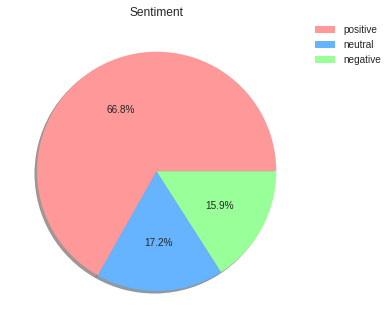

In [ ]:
colors = pd.Series(['#ff9999','#66b3ff','#99ff99'], index=['positive', 'neutral','negative'])
data = comments['sentiment_ind'].value_counts()
data = data.to_frame()
data.insert(0, "colors", pd.Series(['#ff9999','#66b3ff','#99ff99'], index=['positive', 'neutral','negative']))
#plt.figure(figsize=(8,8))
ax = data.plot(y='sentiment_ind',kind="pie", autopct='%1.1f%%', shadow=True, colors=data['colors'], legend=True, title='Sentiment', ylabel='', labeldistance=None)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

In [ ]:
def condense_categories(df, col_name, max_cat):
    "this function is useful to show only the top max_cat categories and place the rest in the 'other' category"
    df_freq = df[col_name].value_counts().head(max_cat)
    other_count = df[col_name].value_counts()[max_cat:].sum()
    if other_count:
        df_freq.loc['other'] = other_count
    return df_freq

In [ ]:
condense_categories(comments, 'language', 4)

English       464
Portuguese      9
German          8
Spanish         5
other          14
Name: language, dtype: int64

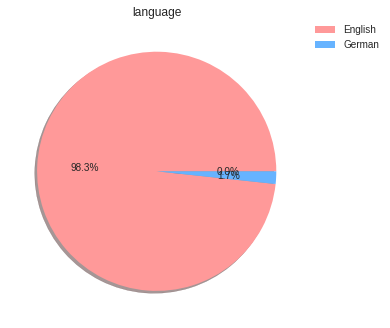

In [ ]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = lang.plot(kind="pie", autopct='%1.1f%%', shadow=True, colors=colors, legend=True, title='language', ylabel='', labeldistance=None)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

In [ ]:
lang = comments['language'].value_counts().head(3)

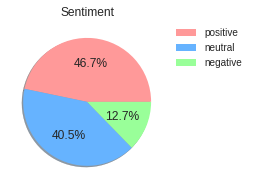

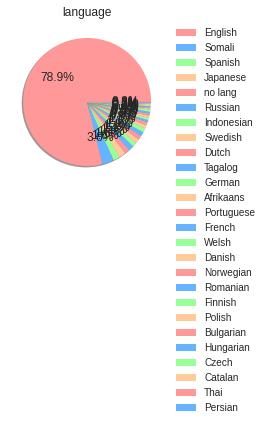

NameError: ignored

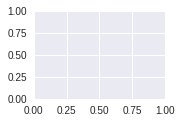

In [ ]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
data = comments['sentiment_ind'].value_counts()
plt.figure(figsize=(10,10))
plt.subplot(3,3,1)
ax = data.plot(kind="pie", autopct='%1.1f%%', shadow=True, colors=colors, legend=True, title='Sentiment', ylabel='', labeldistance=None)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
#plt.show()
data = comments['language'].value_counts()
plt.figure(figsize=(10,10))
plt.subplot(3,3,4)
ax = data.plot(kind="pie", autopct='%1.1f%%', shadow=True, colors=colors, legend=True, title='language', ylabel='', labeldistance=None)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

plt.subplot(3,3,2)
comments_agg.count().plot()
pos_comments.count().plot()
neg_comments.count().plot()


In [ ]:
s_month = comments['published_date'].dt.month
s_year = comments['published_date'].dt.year
comments_agg=comments.groupby([s_year,s_month])['sentiment_score']

In [ ]:
df_pos = comments[comments.sentiment_ind == 'negative']
df_neg = comments[comments.sentiment_ind == 'positive']

In [ ]:
pos_comments = df_pos.groupby([s_year,s_month])['sentiment_score']
neg_comments = df_neg.groupby([s_year,s_month])['sentiment_score']

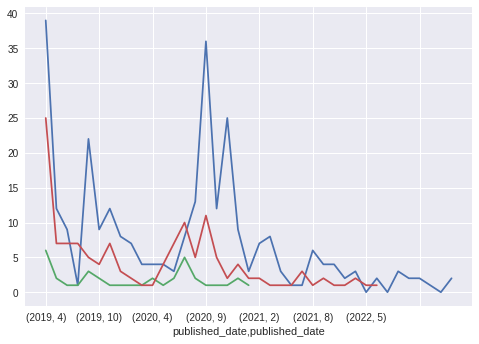

In [ ]:
comments_agg.count().plot()
pos_comments.count().plot()
neg_comments.count().plot()

### timetrend

In [ ]:
chart_data = comments.copy()
ndates = chart_data['published_date'].dt.date.nunique()

In [ ]:
def getyear_month(date):
    if date.month<10:
        return str(date.year)+'-'+'0'+str(date.month)
    return     str(date.year)+'-'+str(date.month)

In [ ]:
if ndates <=60:
    chart_data['date'] = chart_data['published_date'].dt.date
else:
    chart_data['date'] = chart_data['published_date'].apply(getyear_month)

In [ ]:
chart_data_agg = chart_data.groupby(['date', 'sentiment_ind'])['published_date'].count().unstack().fillna(0)
chart_data_agg['total'] = chart_data_agg.sum(axis=1)


Text(0, 0.5, 'comments')

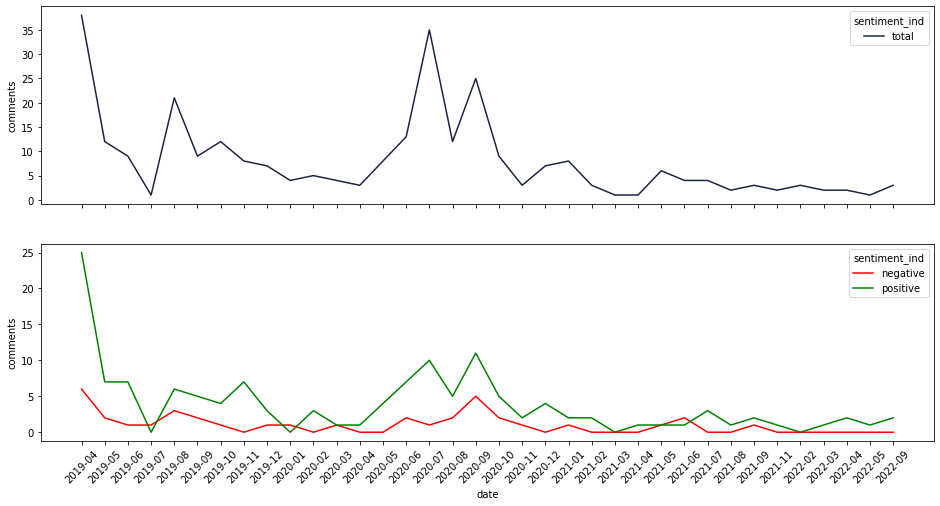

In [ ]:

plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
g1 = sns.lineplot(data=chart_data_agg[['total']])
g1.set(xticklabels=[])
g1.set(xlabel=None)
#chart_data[['total']].plot(color=['blue'])
plt.xticks(rotation=45)
plt.ylabel('comments')

plt.subplot(2,1,2)
ax =sns.lineplot(data=chart_data_agg[['negative','positive']], dashes=False, palette={'positive':'green', 'negative':'red'})
#chart_data[['negative','positive']].plot(color=['red','green'])
plt.xticks(rotation=45)
plt.ylabel('comments')



#plt.subplot(2,2,1)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

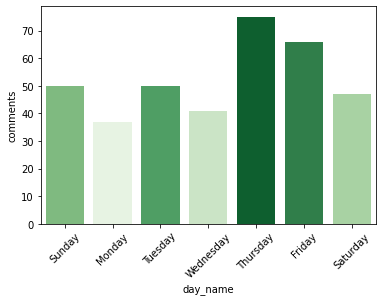

In [ ]:
cats = {'Sunday':1, 'Monday':2, 'Tuesday':3, 'Wednesday':4, 'Thursday':5, 'Friday':6, 'Saturday':7}
chart_data_2 = comments.copy()
chart_data_2['day_name'] = chart_data_2['published_date'].dt.day_name()
chart_data_2 = chart_data_2.groupby(['day_name'])['published_date'].count().fillna(0).reset_index()
chart_data_2['day_name_order'] = chart_data_2['day_name'].map(cats)
chart_data_2 = chart_data_2.sort_values('day_name_order')
chart_data_2.rename(columns={'published_date':'comments'}, inplace=True)

pal = sns.color_palette("Greens_r", len(chart_data_2))
rank = chart_data_2.set_index('day_name')['comments'].argsort().argsort()
sns.barplot(data=chart_data_2, x='day_name', y='comments', palette=np.array(pal[::-1])[rank])
plt.xticks(rotation=45)


###API Detect language

In [ ]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 16.1 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=9154122c3de0cb5debc878be070ab8009c8856674fc752eaf7794a802c6f88ef
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji


In [ ]:
!pip install polyglot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 9.1 MB/s 
  Created wheel for polyglot: filename=polyglot-16.7.4-py2.py3-none-any.whl size=52577 sha256=3979d6d4f4e15a6879d22d8bf1ef01e6c08cc33f8231d94a82decf000af96db5
  Stored in directory: /root/.cache/pip/wheels/09/bc/67/75c9de8e9726460bc0b101ad225ad025cb8ce9e0759beb9d52
Successfully built polyglot


In [ ]:
!pip install pyicu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 305 kB 8.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyicu: filename=PyICU-2.9-cp37-cp37m-linux_x86_64.whl size=1375560 sha256=3d68da0f68ca2eb0f4c1c6fd7531d7e4befd579ab18a6cfacf5d596ff202043a
  Stored in directory: /root/.cache/pip/wheels/28/88/93/6c1b06361e4cbd4e7f793fb456729f69798f9aa3fc2a791cd7
Successfully built pyicu


In [ ]:
!pip install pycld2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.4 MB 1.1 MB/s 
  Created wheel for pycld2: filename=pycld2-0.41-cp37-cp37m-linux_x86_64.whl size=9834146 sha256=029a77b8b3e66be76f67d8d68b4f12dc8851d9ba963d7a977a00ece8a9bc9e7e
  Stored in directory: /root/.cache/pip/wheels/ed/e4/58/ed2e9f43c07d617cc81fe7aff0fc6e42b16c9cf6afe960b614
Successfully built pycld2


In [ ]:
!pip install morfessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from polyglot.detect import Detector

In [ ]:
Detector('i am so hype	').language.name

'English'

In [ ]:
def get_lang_2(text):
    return Detector(text, quiet=True).language.name

In [ ]:
from emoji import demojize, replace_emoji

In [ ]:
text_dict = comments['textOriginal'].to_dict()

In [ ]:
api_input = [{"speaker":str(key), "utterance":value} for key, value in text_dict.items()]

In [ ]:
api_input

In [ ]:
comments['textOriginal'].head(10)

###text proofread

In [46]:
num = 12345678

In [47]:
print(f'{num:,}')

12,345,678


In [44]:
def clean_text(phrase):
    def decontracted(phrase):
        # specific
        phrase = re.sub(r"won\'t", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase

    phrase = phrase.lower()
    phrase = re.sub(r'(http|@)\S+', "",phrase)
    phrase = replace_emoji(phrase,replace="")
    phrase = re.sub(r"’", "'",phrase)
    phrase = re.sub(r"[^a-z\':_]", " ",phrase)
   #phrase = re.sub(r"(can't|cannot)", 'can not',phrase)
    phrase = decontracted(phrase)
    phrase = phrase.replace(":","")
    phrase = phrase.replace("'","")
    phrase = re.sub(r'^\s*|\s\s*', ' ', phrase).strip()
    return phrase

In [42]:
text = "I can’t believe after 13 years of being a Percy fan I’m getting what looks like an utterly perfect adaptation. Thank you Rick, Walker, Leah, Aryan and the whole team for putting so much work into this project. This is the story telling Seaweed Brain deserves!"

In [45]:
clean_text(text)

'i can not believe after years of being a percy fan i am getting what looks like an utterly perfect adaptation thank you rick walker leah aryan and the whole team for putting so much work into this project this is the story telling seaweed brain deserves'

In [ ]:
clean_text("I can’t believe after 13 years of being a Percy fan I’m getting what looks like an utterly perfect adaptation. Thank you Rick, Walker, Leah, Aryan and the whole team for putting so much work into this project. This is the story telling Seaweed Brain deserves!")

'i can not believe after years of being a percy fan i am getting what looks like an utterly perfect adaptation thank you rick walker leah aryan and the whole team for putting so much work into this project this is the story telling seaweed brain deserves'

In [ ]:
pd.options.display.max_colwidth = 400

In [ ]:
comments['sentence_len'] = comments['clean'].apply(len)

In [ ]:
comments['word_count'] = comments['clean'].apply(str.split).apply(len)

In [ ]:
data = comments[['likeCount', 'replyCount', 'sentence_len', 'word_count', 'sentiment_ind']]

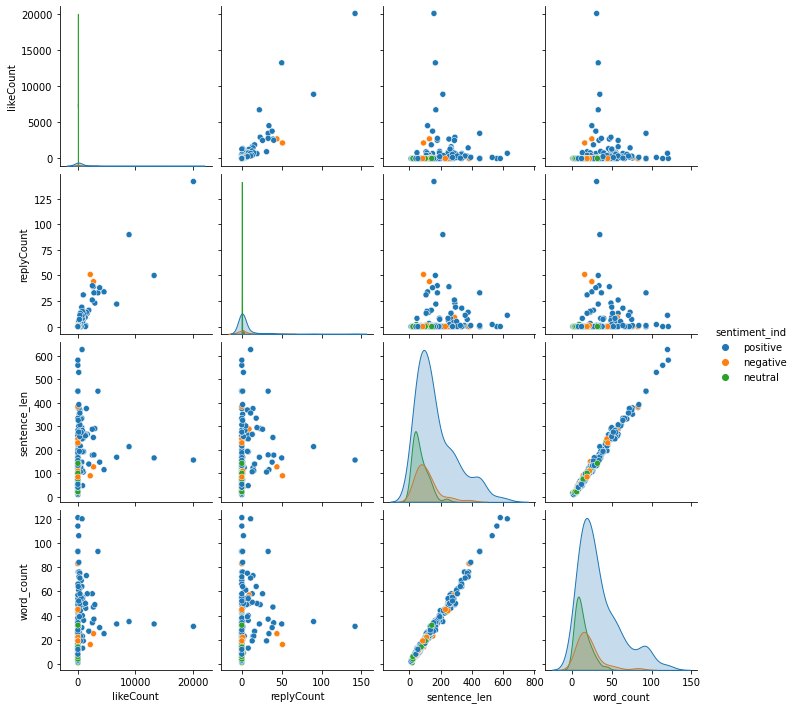

In [ ]:
sns.pairplot(data, hue='sentiment_ind')

In [ ]:
comments.loc[comments['sentence_len']> 400]['textOriginal'].drop_duplicates()

8      What I think is going to really make this series different is the age appropriate casting. Even when I read the books as a pre-teen it didn’t dawn on me about how young they were, because, well, they were my age! Now that I’m an adult it’s crazy to see how much the characters will have to go through at such young ages. I think the cast has been set perfectly and with Rick Riordan being one of ...
59     I’ve been reading Percy Jackson since 2007. Mind you, the books first published in 2005. I have quite literally, grown up with Percy Jackson and I cannot wait to see what they do with this series!!! Pulling the lines from the book is so promising, and (if they get there) I can’t wait to see what other lines they pull straight from the book! My hopes on those are mostly the “I can see the stars...
95     Love that they are actual kids, love the vibes, love that it's clearly going to have the spirit and character of the books but WHY didn't they dye his hair or give Percy a wig? Li

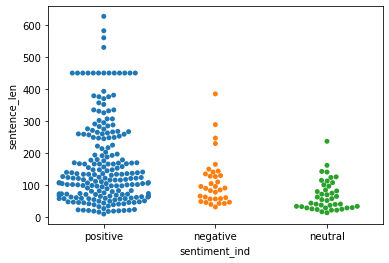

In [ ]:
sns.swarmplot(data=comments, y='sentence_len', x='sentiment_ind')

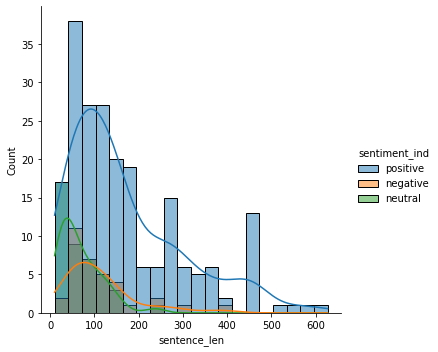

In [ ]:
sns.displot(data=comments, x='sentence_len', bins=20, kde=True, hue='sentiment_ind')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


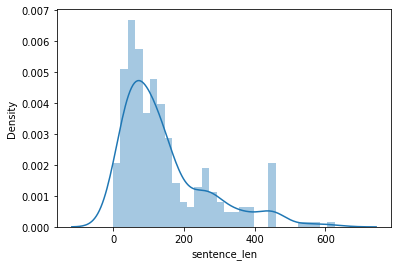

In [ ]:
sns.distplot(comments.sentence_len, bins=30)

In [ ]:
comments[['textOriginal','text_clean']].head(40)

,textOriginal,text_clean
0,I love the fact that they actually let them be kids. Too often these shows age them up and/or cast 25-year olds as ‘teens’.,i love the fact that they actually let them be kids. too often these shows age them up and/or cast 25-year olds as ‘teens'.
1,"The fact that the Owl wasn’t planned and was just there on that day of shooting, only to create a new sense of depth by symbolizing Athena is genius","the fact that the owl was not planned and was just there on that day of shooting, only to create a new sense of depth by symbolizing athena is genius"
2,"A series that seems like it's actually gonna pay respect to the culture and writings from which it originates, am I dreaming?","a series that seems like it's actually gonna pay respect to the culture and writings from which it originates, am i dreaming?"
3,"I can’t believe they didn’t cast Charlie, even after carrying the hunger games franchise","i ca not believe they did not cast charlie, even after carrying the hunger games franchise"
4,I thought that they finally made a sequel :3,i thought that they finally made a sequel 3
5,The opening narration mirroring the first few lines from the book has got me excited and can't wait to see how much more care and detail is being put into this show,the opening narration mirroring the first few lines from the book has got me excited and ca not wait to see how much more care and detail is being put into this show
6,"For years I’ve waited to see my childhood come to life. There is a certain sense I got hearing the first speech because that’s the speech that got my hooked on the series, the entire reason I associate myself with who I am today. It’s impossible to correctly put into words just how much this series already means to me, but my fifth grade self would go wild at the thought of it :)","for years i've waited to see my childhood come to life. there is a certain sense i got hearing the first speech because that's the speech that got my hooked on the series, the entire reason i associate myself with who i am today. it's impossible to correctly put into words just how much this series already means to me, but my fifth grade self would go wild at the thought of it )"
7,"The Percy Jackson books made up my childhood, and seeing a detailed and accurate movie representation of it (even if it’s just the teaser currently) makes my inner demigod and younger self so happy!! 😭😭 the cabins, the dialogue, the owl, the aesthetic!! It’s all so good!!","the percy jackson books made up my childhood, and seeing a detailed and accurate movie representation of it (even if it's just the teaser currently) makes my inner demigod and younger self so happy!! the cabins, the dialogue, the owl, the aesthetic!! it's all so good!!"
8,"What I think is going to really make this series different is the age appropriate casting. Even when I read the books as a pre-teen it didn’t dawn on me about how young they were, because, well, they were my age! Now that I’m an adult it’s crazy to see how much the characters will have to go through at such young ages. I think the cast has been set perfectly and with Rick Riordan being one of ...","what i think is going to really make this series different is the age appropriate casting. even when i read the books as a pre-teen it did not dawn on me about how young they were, because, well, they were my age! now that i'm an adult it's crazy to see how much the characters will have to go through at such young ages. i think the cast has been set perfectly and with rick riordan being one of..."
9,"What I think is going to really make this series different is the age appropriate casting. Even when I read the books as a pre-teen it didn’t dawn on me about how young they were, because, well, they were my age! Now that I’m an adult it’s crazy to see how much the characters will have to go through at such young ages. I think the cast has been set perfectly and with Rick Riordan being one of ...","what i think is going

###bar chart emotions

In [ ]:
text_dict = comments.loc[comments['language']=='English']['textOriginal'].to_dict()

In [ ]:
api_input = [{"speaker":str(key), "utterance":value} for key, value in text_dict.items()]

In [ ]:
# Edit this One AI API call using our studio at https://studio.oneai.com/?pipeline=gZ9b3p

import requests

api_key = "*****"
url = "https://api.oneai.com/api/v0/pipeline"
headers = {
  "api-key": api_key, 
  "content-type": "application/json"
}
payload = {
  "input": api_input,
  "input_type": "conversation",
	"content_type": "application/json",
  "steps": [
      {
      "skill": "emotions"
    }
    ],
  }
r = requests.post(url, json=payload, headers=headers)
data = r.json()

In [ ]:
emotions = data['output'][0]['labels']

In [ ]:
emotions_df =   pd.DataFrame([{key:value for key, value in element.items() if key in ['speaker', 'name', 'span_text']} for element in emotions])

In [ ]:
#emotions_df.loc[emotions_df['speaker']=='43']

In [ ]:
emotions_df['speaker'] = emotions_df['speaker'].astype('int')

In [ ]:
emotions_agg_df = emotions_df.groupby('speaker')['name'].value_counts().unstack().sort_index()

In [ ]:
comments_df = comments.join(emotions_agg_df).fillna(0)

In [ ]:
comments_df.iloc[37][['textOriginal', 'sentiment_ind', 'sentiment_score']]

textOriginal       This is absolutely amazing, and my heart raced at every word that I know so well from the lines of the book, I am so excited for this series. Its been a long time coming
sentiment_ind                                                                                                                                                                       positive
sentiment_score                                                                                                                                                                       0.8735
Name: 37, dtype: object

In [ ]:
comments_df.iloc[30:50,-4:]

,anger,happiness,sadness,surprise
30,0.0,2.0,0.0,0.0
31,0.0,7.0,1.0,0.0
32,0.0,1.0,1.0,0.0
33,0.0,2.0,0.0,0.0
34,0.0,1.0,0.0,0.0
35,0.0,0.0,0.0,0.0
36,0.0,1.0,0.0,0.0
37,0.0,1.0,0.0,0.0
38,0.0,0.0,0.0,0.0
39,0.0,1.0,0.0,0.0


In [ ]:
comments_df[['anger', 'happiness', 'sadness','surprise']].sum(axis=1).sort_values(ascending=False)

31     8.0
218    7.0
100    4.0
56     4.0
267    4.0
      ... 
268    0.0
266    0.0
265    0.0
264    0.0
499    0.0
Length: 500, dtype: float64

In [ ]:
comments_df[['anger', 'happiness', 'sadness','surprise']] =  comments_df[['anger', 'happiness', 'sadness','surprise']].applymap(lambda x:1 if x > 0 else 0)

In [ ]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   textOriginal     500 non-null    object        
 1   likeCount        500 non-null    int64         
 2   published_date   500 non-null    datetime64[ns]
 3   replyCount       500 non-null    int64         
 4   language         500 non-null    object        
 5   sentiment_score  458 non-null    float64       
 6   sentiment_ind    458 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 27.5+ KB


In [ ]:
comments.loc[:,['sentiment_ind', 'sadness', 'happiness', 'anger', 'surprise']]

KeyError: ignored

In [ ]:
emotions_data = comments_df.loc[comments_df['sentiment_ind']!=0].groupby('sentiment_ind')['sadness','happiness','anger','surprise'].sum().reset_index().melt(id_vars='sentiment_ind',var_name='emotion',value_name='freq')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
emotions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sentiment_ind  12 non-null     object
 1   emotion        12 non-null     object
 2   freq           12 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 416.0+ bytes


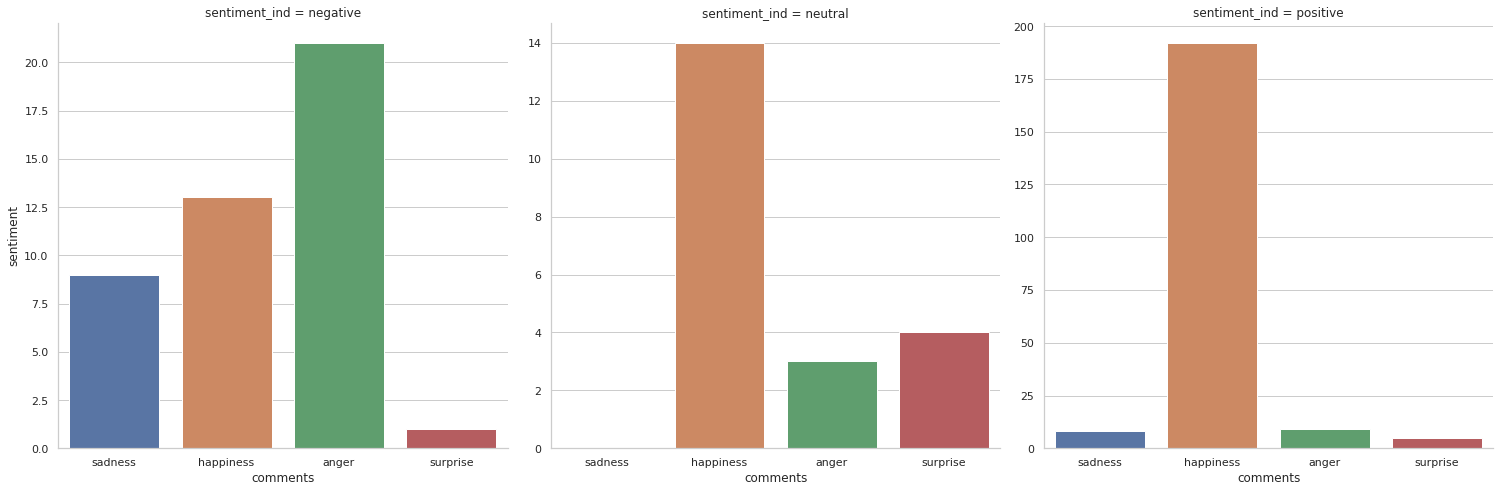

In [ ]:
#sns.set_theme(style="whitegrid")
g = sns.catplot(data=emotions_data, kind='bar', col='sentiment_ind', x='emotion', y='freq', orient='v', height=7, sharey=False)
g.set_axis_labels('comments','sentiment')

#new_labels = ['saddness','happiness','anger','surprise']

#for t, l in zip(g._legend.texts, new_labels):
#    t.set_text(l)

#plt.title("comments by sentiment and and emotion", fontsize=20)


In [ ]:
comments_df = pd.concat([comments, pd.json_normalize(comments['emotions'])], axis=1)
comments_df[['sadness_ind','happiness_ind','anger_ind','surprise_ind']] = comments_df[['sadness','happiness','anger','surprise']].notna()
emotions_agg = comments_df.groupby('sentiment_ind')['sadness_ind','happiness_ind','anger_ind','surprise_ind'].sum().reset_index().melt(id_vars='sentiment_ind',var_name='emotion',value_name='freq')

In [ ]:
sns.set_theme(style="whitegrid")
g = sns.catplot(data=emotions_agg, kind='bar', x='freq', y='sentiment_ind', hue='emotion', orient='h', height=7)
g.set_axis_labels('comments','sentiment')

new_labels = ['saddness','happiness','anger','surprise']

for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

plt.title("comments by sentiment and and emotion", fontsize=20)


### analyzie top 10 comments by sentiemt

In [ ]:
#max_like_count=1
#max_reply_count=1
comments['engagement'] = (15*comments['replyCount']+comments['likeCount'])

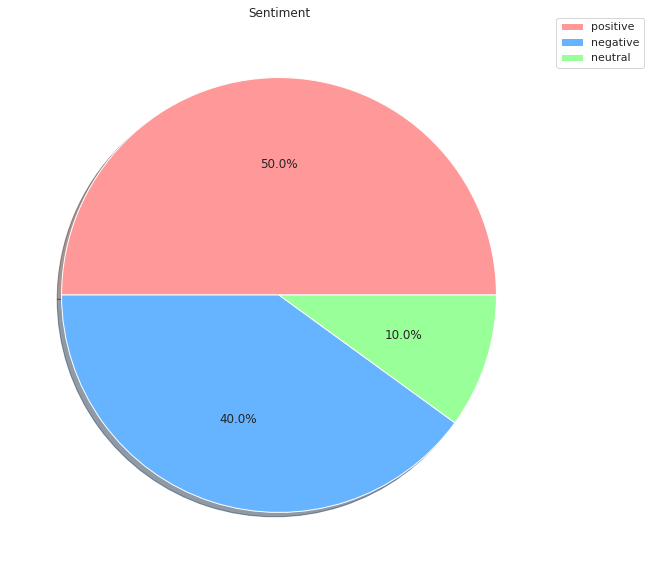

In [ ]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
data = comments.nlargest(10,'engagement')['sentiment_ind'].value_counts()
plt.figure(figsize=(10,10))
ax = data.plot(kind="pie", autopct='%1.1f%%', shadow=True, colors=colors, legend=True, title='Sentiment', ylabel='', labeldistance=None)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

###word cloud

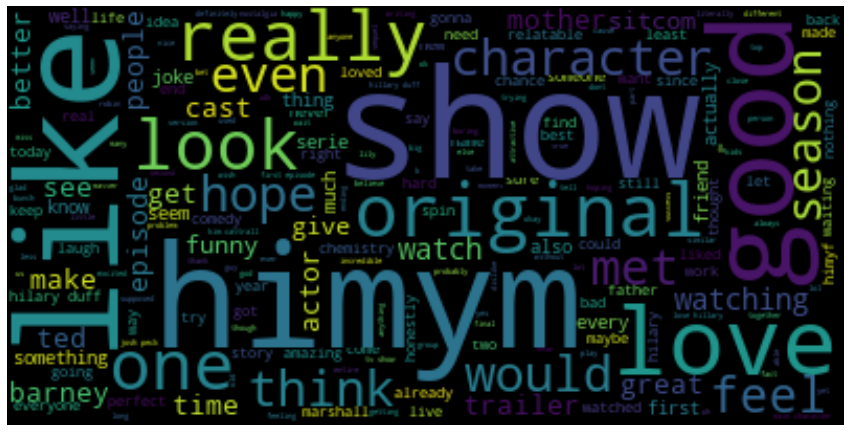

In [ ]:
comments_pos = comments.loc[comments['sentiment_ind']=='positive',['textOriginal']].squeeze()
comments_pos = comments_pos.apply(text_preprocess).apply(lambda row:row.get('clean_text').get('text'))
get_wordcloud(comments_pos)

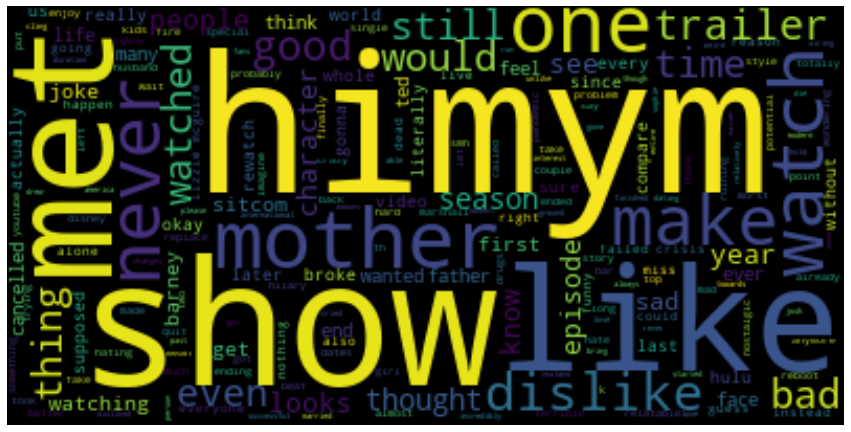

In [ ]:
comments_neg = comments.loc[comments['sentiment_ind']=='negative',['textOriginal']].squeeze()
comments_neg = comments_pos.apply(text_preprocess).apply(lambda row:row.get('clean_text').get('text'))
get_wordcloud(comments_neg)

##Testing

In [ ]:
comments

,textOriginal,likeCount,published_date,replyCount,language,sentiment_score,sentiment_ind
0,I love the fact that they actually let them be...,4368,2022-09-12 15:19:00,34,English,0.6369,positive
1,The fact that the Owl wasn’t planned and was j...,535,2022-09-14 21:43:01,0,English,0.2732,positive
2,A series that seems like it's actually gonna p...,465,2022-09-14 20:00:35,10,English,0.6369,positive
3,"I can’t believe they didn’t cast Charlie, even...",2084,2022-09-14 20:15:16,51,English,-0.2500,negative
4,I almost cried when I heard walker say “look I...,83,2022-09-14 03:43:24,1,English,0.8034,positive
...,...,...,...,...,...,...,...
495,i also love how they all look so age appropria...,9,2022-09-11 06:09:07,1,English,0.8885,positive
496,I AM SCREEAAMMIINNGGGG RIGHTTT NOWWWW!!!!!!!!!...,0,2022-09-23 14:59:07,0,English,0.0000,neutral
497,justice for charlie!!!!!,4,2022-09-14 19:45:57,0,Romanian,NaN,NaN
498,"One thing is missing, it makes the whole show ...",2,2022-09-15 02:13:21,0,English,-0.7419,negative


In [ ]:
pd.get_dummies(emotions_df)

name_anger         35
name_happiness    311
name_sadness       18
name_surprise      10
dtype: int64

In [ ]:
[{key:value}  for element in emotions[:2] for key, value in element.items() if key in ['speaker', 'name', 'span_text']]

[{'name': 'happiness'},
 {'speaker': '0'},
 {'span_text': 'I love the fact that they actually let them be kids.'},
 {'name': 'surprise'},
 {'speaker': '3'},
 {'span_text': 'I can’t believe they didn’t cast Charlie, even after carrying the hunger games franchise'}]

In [ ]:
{emotion['name']:emotion['span_text'] for emotion in emotions}

{'happiness': 'i also love how they all look so age appropriate bc i remember reading this series when i was 12 and being super excited that there were characters my age',
 'surprise': 'Absolutely unbelievable how Charles White was not casted as percy.',
 'anger': 'One thing is missing, it makes the whole show seems very bad and that is that Charlie isn’t Percy Jackson!',
 'sadness': "Is it only me wondering if sadly I'll be to old to watch this when it comes out"}

In [ ]:
comments['textOriginal'][:2].apply(lambda row:{"speaker":row.index})

0    {'speaker': <built-in method index of str obje...
1    {'speaker': <built-in method index of str obje...
Name: textOriginal, dtype: object

In [ ]:
classifier = pipeline("text-classification",model='bhadresh-savani/bert-base-uncased-emotion', return_all_scores=False)

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


In [ ]:
classifier("This is literally everything I ever wanted . Especially the opening lines . I can tell that the series is gonna be a blast	",)

[{'label': 'joy', 'score': 0.8938063979148865}]

In [ ]:
text = "This is literally everything I ever wanted . Especially the opening lines . I can tell that the series is gonna be a blas"

In [ ]:
prediction = classifier(text)

In [ ]:
prediction

[{'label': 'joy', 'score': 0.8442046046257019}]

In [ ]:
prediction[0].get('label')

'joy'

In [ ]:
def get_emotion_2(text):
    prediction = classifier(text)
    score = prediction[0].get('score')
    label = prediction[0].get('label')
    if score < 0.7:
        return None
    else:
        return label

In [ ]:
comments['emotion'] = comments['textOriginal'].apply(get_emotion_2)

In [ ]:
comments['emotion'].value_counts()

joy         337
anger        50
sadness      21
fear         11
surprise      5
love          4
Name: emotion, dtype: int64

In [ ]:
pd.json_normalize(classifier(text)[0]).sort_values('score', ascending=False).head(1).values[0,0]

In [ ]:
pd.json_normalize(comments['emotions'])

,sadness,happiness,anger,surprise
0,It's times like these that I'm incredibly sad to not be able to see the amount of dislikes anymore,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,"It's nice to see that even 8 years after its final episode, people still continue to love and cherish the, in what is just my humble opinion, best sitcom ever created.",NaN,NaN
4,NaN,They were outstanding,NaN,NaN
...,...,...,...,...
495,NaN,NaN,NaN,NaN
496,NaN,NaN,NaN,NaN
497,NaN,NaN,I hate how clearly they’re trying to make the cast diverse,NaN
498,NaN,NaN,NaN,NaN


In [ ]:
#comments_df.loc[comments_df[['sadness','happiness','anger','surprise']].isna().sum(axis=1)<3]

,textOriginal,likeCount,published_date,replyCount,language,sentiment_score,sentiment_ind,emotions,sadness,happiness,anger,surprise
46,"I miss the old times where the jokes were clever, funny and just ""free"" of judgment. The times were sitcoms were about real friendship, with relatable life's, and normal awesome people. I miss waiting for every episode because there was no Netflix, HBO, or even a way to record it. We waited for ...",1,2022-05-21 00:47:05,0,English,0.9118,positive,"{'happiness': 'We waited for every episode and they were all magical.', 'sadness': 'I just wish we could still wait for it 🤍✨'}",I just wish we could still wait for it 🤍✨,We waited for every episode and they were all magical.,NaN,NaN
55,"I just watched it tonight, and it was actually pretty good. Had a good laugh and the first episode had a nice twist to it that I did not expect at all. \nThe very corny trailer did not give it justice.",18,2022-01-19 20:29:10,0,English,0.9122,positive,"{'happiness': 'Had a good laugh and the first episode had a nice twist to it that I did not expect at all.', 'anger': 'The very corny trailer did not give it justice.'}",NaN,Had a good laugh and the first episode had a nice twist to it that I did not expect at all.,The very corny trailer did not give it justice.,NaN
219,"This might be ok but it'll never hold a candle to the original to me at least, it had heart it was funny you could laugh at a scenes and rewatch it and cry at it for example barney singing cats in the cradle funny when you first watch it but rewatching with the knowledge of barney's upbringing i...",0,2022-01-25 10:41:46,0,English,0.9911,positive,"{'sadness': 'This might be ok but it'll never hold a candle to the original to me at least, it had heart it was funny you could laugh at a scenes and rewatch it and cry at it for example barney singing cats in the cradle funny when you first watch it but rewatching with the knowledge of barney's...","This might be ok but it'll never hold a candle to the original to me at least, it had heart it was funny you could laugh at a scenes and rewatch it and cry at it for example barney singing cats in the cradle funny when you first watch it but rewatching with the knowledge of barney's upbringing i...","taught real honest and good life lessons, it also introduced me to amazing bands and music, the chemistry between the actors the writing was amazing, this show just has giant shoes to attempt to fill.",NaN,NaN


###language transfer

In [ ]:
comments['language'].apply(lambda x:languages.get(alpha2=x).name)

0         English
1         English
2         English
3      Portuguese
4         English
          ...    
145       English
146       English
147       English
148       English
149       English
Name: language, Length: 150, dtype: object

###text pre-processing

In [ ]:
text = """The “me and your mom making love” editing was so slick some people might not have even gotten that 😂😂😂
Great vid as always guys. I suggested AM on the last Arctic Monkeys video; you love to see it!
Edit: Knee Socks is an absolute bop"""

In [ ]:
text_dict = text_preprocess(text)

In [ ]:
text_dict['clean_text']

{'text': 'the me and your mom making love editing was so slick some people might not have even gotten that great vid as always guys i suggested am on the last arctic monkeys video you love to see it edit knee socks is an absolute bop',
 'text_len': 45}

In [ ]:
text_dict['origianl_text']

{'text': 'The “me and your mom making love” editing was so slick some people might not have even gotten that 😂😂😂\nGreat vid as always guys. I suggested AM on the last Arctic Monkeys video; you love to see it!\nEdit: Knee Socks is an absolute bop',
 'text_len': 52}

In [ ]:
sent_tokenize(text)

['The me and your mom making love editing was so slick some people might not have even gotten that Great vid as always guys I suggested AM on the last Arctic Monkeys video you love to see it Edit Knee Socks is an absolute bop']

###controling comment amount

In [ ]:
id = video_id('https://www.youtube.com/watch?v=SwSbnmqk3zY&ab_channel=techTFQ')

In [ ]:
#make sure to not pull more data then needed
comments = getcomments(id,maxResults=60)

maxResults: 60
n_results: 60


In [ ]:
len(comments)

176

In [ ]:
comment_list = getcomments('-tJYN-eG1zk', maxResults=100)

maxResults: 100
n_results: 100


In [ ]:
len(comment_list)

100

In [ ]:
comment_text=[comment['snippet']['topLevelComment']['snippet']['textDisplay'] for comment in comment_list]

In [ ]:
comment_text[0:5]

['It doesn’t matter who you are, you were born knowing this beat',
 'Rock is not dead yet and never will be!  Respect to Brian May too.',
 'This song is usually used when the football teams are entering the stadium, football field, like I experienced this in Manchester, many years ago 👍👍👍👍',
 'igual de leyenda que la banda',
 'RIP queen ❤️']

In [ ]:
comments=parse_comments(comments)
comments.head(10).style.set_properties(**{'text-align': 'left'})

,textOriginal,likeCount,published_date,replyCount
0,"Hi Thoufiq, this is very impressive! I’m watching this purely out of curiosity bc I’ve not started my python class yet; however, I would love to see SQL project ideas, maybe for data cleaning and/or analysis. Thanks as always for your clear explanations and guidance 👍🏻 Also very glad to see you’re closing in on 15K, friend!! Congratulations in advance 😀👌🏻🙏🏻",2,2021-11-17 14:18:01,1
1,"Great tutorial! I was wondering how you click and paste all the outcome after running a cells so quickly. The copy and paste to the JSON formartter is really useful but dragging the mouse to copy the output is a pain. I've noticed you don't do that and tried to find a way to do the same, but did not succeed.",0,2022-08-18 18:58:52,0
2,"This is impresive and easy to follow,👌🏻 however Youtube disabled the dislike count( The statistics.dislikeCount property was made private as of December 13, 2021. This means that the property is included in an API response only if the API request was authenticated by the video owner.) and this will affect the function to get video details.",2,2022-06-13 19:48:09,0
3,"Great videos sir! Its very helpful! Sorry for my bad English, but I want to ask you about groupby in your videos around 1:03:10 How can I show the number of uploaded videos per month in ordered years (years not omitted)?? Thank you in advance.",0,2022-08-21 17:59:49,0
4,"Thanks, Brother. This was a bit intricate for me as I have just started out learning Python for Data Analysis but the tricks you have used are new and I am eager to learn and use them and create a new project based off of this information. Don't worry, keep at it, you will be bigger than Ken Jee one day, just stay consistent.",2,2021-12-18 19:01:24,1
5,Thanks for creating this project. I watched it like an action movie :) and going to learn bit by bit again by creating the same project again.,0,2022-07-11 15:00:39,0
6,"Hi Thoufiq, excellent video absolutely loved it please keep creating many more project videos. Can you make a short video on how to visualize data using python as Dynamic Radar Charts (i.e Player vs player comparision/company vs company - you can filter which two competitors to compare)",4,2021-12-23 09:22:43,3
7,"Hi! congrats for the tutorial, is really clearly explained! I have a question, what if I want to extract the comments from every video of a given playlists of a channel? How can I do that? Thank you!!",0,2022-09-07 14:26:19,0
8,"Hi sir, thank you for your tutorial. it's very helpful for my research project. However, I have a problem when I tried to scrape video data from channels that have more 40,000 videos uploaded. The scraper returns only 20,000 video data. Any suggestion to fix this issue?",0,2022-06-22 06:04:46,0
9,"Hi Thoufiq, great tutorial! Just getting started here with Python. One quick question. I don't see the YT-env in my jupyter notebook, but did start jupyter from the YT-env in my terminal. Any idea on where this went wrong? Kind regards! Stephan",2,2021-11-23 13:56:48,1


In [ ]:
sentiment_analysis('Hi! congrats for the tutorial, is really clearly explained! I have a question, what if I want to extract the comments from every video of a given playlists of a channel? How can I do that? Thank you!!	')

'positive'

In [ ]:
text = 'Love this song Queen is the best ❤️❤️❤️💥💥💥'

In [ ]:
emo=LeXmo.LeXmo(text)
print(emo)

{'text': 'Love this song Queen is the best ❤️❤️❤️💥💥💥', 'anger': 0.0, 'anticipation': 0.0, 'disgust': 0.0, 'fear': 0.0, 'joy': 0.125, 'negative': 0.0, 'positive': 0.125, 'sadness': 0.0, 'surprise': 0.0, 'trust': 0.0}


In [ ]:
comments['sentiment_score']=comments['textOriginal'].apply(sentiment_analysis_compound_score)
comments['sentiment_ind']=comments['textOriginal'].apply(sentiment_analysis)

In [ ]:
comments['language']=comments['textOriginal'].apply(get_language)

In [ ]:
comments.sort_values('sentiment_score').head(90).style.set_properties(**{'text-align': 'left'})

,textOriginal,likeCount,published_date,replyCount,sentiment_score,sentiment_ind,language
1,"Great tutorial! I was wondering how you click and paste all the outcome after running a cells so quickly. The copy and paste to the JSON formartter is really useful but dragging the mouse to copy the output is a pain. I've noticed you don't do that and tried to find a way to do the same, but did not succeed.",0,2022-08-18 18:58:52,0,-0.674400,negative,en
58,Hi! What to do if I don't have this 'YT-env' in new notebook drop menu in jupyter?,1,2022-02-12 18:11:41,0,-0.338200,negative,en
34,"Hi Im new to Data Analysis and I wanna know, the first part you are doing by scrapping or collected data is that Data Engineering?",1,2022-08-17 22:25:40,2,0.000000,neutral,en
47,"Bro, is there any way with js to get channel id for channels that have customURL?",0,2022-03-27 01:04:03,0,0.000000,neutral,en
51,If possible deployment at repositories also be preferred,0,2021-10-14 21:39:12,0,0.000000,neutral,en
44,"Hi Sir, is it possible to scrape numbers from justdial?",0,2022-02-16 11:37:59,0,0.000000,neutral,en
19,"Hey taufiq, how to prepare/ask these questions while practicing SQL with datasets? Elaborate in detail in upcoming videos.",1,2021-12-25 18:14:21,1,0.000000,neutral,en
38,"hi, could you please help me out. i have just started out with python and some aspects seem too overwhelming. i am working through it but would be really helpful if you could help with this one error. in jupyter, i am getting an error that no module is found for googleapiclient.discovery",0,2022-08-16 13:32:29,0,0.074500,positive,en
2,"This is impresive and easy to follow,👌🏻 however Youtube disabled the dislike count( The statistics.dislikeCount property was made private as of December 13, 2021. This means that the property is included in an API response only if the API request was authenticated by the video owner.) and this will affect the function to get video details.",2,2022-06-13 19:48:09,0,0.077200,positive,en
42,"Hi Sir,i am working on ur project ryt nw,but unable to execute the codes properly,either we are getting an error or we are not getting output . Can you pls help us sir",0,2021-12-16 18:26:16,0,0.077200,positive,en


In [ ]:
sentiment_analysis('I dont dont care about you')

'positive'

In [ ]:
text = 'I dont love you at all, get out of here'

In [ ]:
sentiment_analysis(text)

'negative'

In [ ]:
textobject = NRCLex('Hi Thoufiq, this is very impressive! I’m watching this purely out of curiosity bc I’ve not started my python class yet; however, I would love to see SQL project ideas, maybe for data cleaning and/or analysis. Thanks as always for your clear explanations and guidance 👍🏻 Also very glad to see you’re closing in on 15K, friend!! Congratulations in advance 😀👌🏻🙏🏻')

In [ ]:
textobject = NRCLex(text)

In [ ]:
textobject.affect_frequencies

{'fear': 0.0,
 'anger': 0.0,
 'anticip': 0.0,
 'trust': 0.0,
 'surprise': 0.0,
 'positive': 0.5,
 'negative': 0.0,
 'sadness': 0.0,
 'disgust': 0.0,
 'joy': 0.5}

In [ ]:
emo = LeXmo.LeXmo(text)

In [ ]:
textobject.raw_emotion_scores

{'joy': 1, 'positive': 1}

In [ ]:
textobject.top_emotions

[('positive', 0.5), ('joy', 0.5)]

In [ ]:
textobject.affect_dict

{'love': ['joy', 'positive']}

In [ ]:
textobject.lexicon['love']

['joy', 'positive']

###Other

In [ ]:
video_id('https://www.youtube.com/watch?v=-tJYN-eG1zk&ab_channel=QueenOfficial')

'-tJYN-eG1zk'

In [ ]:
# Edit this One AI API call using our studio at https://studio.oneai.com/?pipeline=7IWWT8

import requests

  
api_key = "40b7dbd3-eb8c-4aca-b395-95a80706a6ed"
url = "https://api.oneai.com/api/v0/pipeline"
headers = {
  "api-key": api_key, 
  "content-type": "application/json"
}
payload = {
  "input": "It doesn’t matter who you are, you were born knowing this beat",
  "input_type": "article",
  "steps": [
    {
      "skill": "sentiments"
    }
  ],
}
r = requests.post(url, json=payload, headers=headers)
data = r.json()
my_dict = data

In [ ]:
import pprint 
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(my_dict)

{   'input_text': 'It doesn’t matter who you are, you were born knowing this '
                  'beat',
    'output': [   {   'labels': [   {   'output_spans': [   {   'end': 62,
                                                                'section': 0,
                                                                'start': 0}],
                                        'skill': 'sentiments',
                                        'span': [0, 62],
                                        'span_text': 'It doesn’t matter who '
                                                     'you are, you were born '
                                                     'knowing this beat',
                                        'type': 'sentiment',
                                        'value': 'POS'}],
                      'text': 'It doesn’t matter who you are, you were born '
                              'knowing this beat',
                      'text_generated_by_step_id': 0,
           

##Tasks

~~figure out how to control the comments amount per api request~~ done on 11/09/2022

~~figure out how to extract most popular comment in another api~~ done on 11/09/2022

~~preprocess the text for sentiment analysis, this requires to figure out how to clean dirty text~~

~~like count - transform into a numbr
published time - transform into a date~~

~~try to create a data frame to use for the analysis~~

add emotion api to detect from text - using NRClex